In [31]:
import pandas as pd
import numpy as np
import spacy
import os
from pathlib import Path
from importlib import reload

In [32]:
import source.prepare_data as prd
import source.dataset as dat
import source.multi_layer_perceptron as mlp
import source.table as tb
import source.comparision as comp
import source.recurent_neural_networks as rnn

In [33]:
reload(prd)
reload(dat)
reload(mlp)
reload(tb)
reload(comp)
reload(rnn)

<module 'source.recurent_neural_networks' from 'C:\\Python_files\\DL_final2\\source\\recurent_neural_networks.py'>

In [34]:
"""
1) Preprocessing
"""
# load models and dataset
df = pd.read_csv("hf://datasets/gxb912/large-twitter-tweets-sentiment/train.csv", nrows=500)
nlp = spacy.load("en_core_web_sm")

# prepare dataset
df = prd.prepare_df(df, nlp)

# create dataset out of cleaned columns
dataset = dat.Text_Dataset(df, col_text="clean_text_str", col_label="sentiment", args={"max_features":5000})
dataset.split_dataset()


In [35]:
df

,sentiment,clean_text,clean_text_str,text
0,1,"[love, you, toooooo, TG, LOL, Gngb]",love you toooooo TG LOL Gngb,@tonigirl14 love you toooooo ! ! TG LOL Gngb
1,0,"[I, tell, myself, do, click, on, this, link, b...",I tell myself do click on this link but I just...,@jun6lee I told myself : Do n't click on this ...
2,0,"[the, man, who, render, his, voice, to, Mickey...",the man who render his voice to Mickey Mouse e...,The man who rendered his voice to Mickey Mouse...
3,1,"[I, think, red, would, be, nice, or, maybe, yo...",I think red would be nice or maybe you could d...,@Shontelle_Layne I think red would be nice . ...
4,0,"[I, guess, one, of, her, tweet, say, she, be, ...",I guess one of her tweet say she be confused,@Silverlines - I guess . 'Cause one of her twe...
...,...,...,...,...
495,1,"[wrong, your, the, skank]",wrong your the skank,[ Wrong ! ] @_ayoobeez --- your the skank . ...
496,0,"[crap, I, just, get, your, tweet, and, my, mom...",crap I just get your tweet and my mom already ...,@meganistkrieg crap i just got your tweet and ...
497,0,"[where, my, sunshine]",where my sunshine,Where 's my sunshine @DONDITO ?
498,0,"[just, wake, up, my, throat, hurt, soi, bad]",just wake up my throat hurt soi bad,just woke up . my throat hurts soi bad


In [36]:
"""
2) Accuracy analysis for MLP model. We will compare the workflow of MLP by using TD-IDF encoding and BOW encoding

2.1) TD-IDF encoding
"""
X_train_TF, X_test_TF, Y_train_TF, Y_test_TF = dataset.get_encodings(tdidf=True)

mlp_tdidf_params = mlp.find_best_mlp(X_train=X_train_TF,
                                      Y_train=Y_train_TF,
                                      X_test=X_test_TF,
                                      Y_test=Y_test_TF,
                                      n_trials = 3,
                                     encoding='TDIDF')

[I 2025-06-18 11:28:06,093] A new study created in memory with name: mlp_optimization
[I 2025-06-18 11:28:07,291] Trial 0 finished with values: [0.5606891512870789, 0.7300000190734863] and parameters: {'epochs': 128, 'learning_rate': 0.24133491544831018, 'units': 6}.
[I 2025-06-18 11:28:08,593] Trial 1 finished with values: [0.6348098516464233, 0.6200000047683716] and parameters: {'epochs': 148, 'learning_rate': 0.16965064454106132, 'units': 5}.
[I 2025-06-18 11:28:10,190] Trial 2 finished with values: [0.588629961013794, 0.699999988079071] and parameters: {'epochs': 193, 'learning_rate': 0.3374981949613684, 'units': 5}.


In [37]:
mlp_tdidf_params

,loss,accuracy,params_epochs,params_learning_rate,params_units,time,trial_time,name
0,0.634810,0.62,148,0.169651,5,1.301589,1.301589,MLP_TDIDF
1,0.588630,0.70,193,0.337498,5,1.596172,1.596172,MLP_TDIDF
2,0.560689,0.73,128,0.241335,6,1.197851,1.197851,MLP_TDIDF


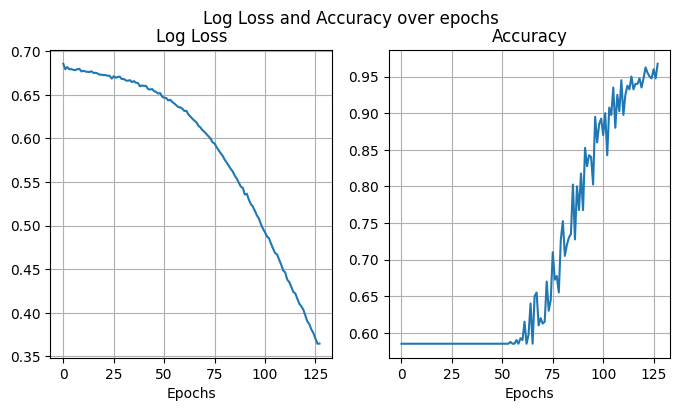

In [38]:
mlp_tdidf = mlp.Feedforward_Model(X_train_TF, Y_train_TF, units=mlp_tdidf_params.iloc[-1]['params_units']) # the last one is the best one
mlp_tdidf.train(LR=mlp_tdidf_params.iloc[-1]['params_learning_rate'], epochs=mlp_tdidf_params.iloc[-1]['params_epochs'])
mlp_tdidf.plot_loss_accuracy()

In [39]:
# Do some tests for vocab size
mlp_tdidf_vocab = comp.test_vocab_size(df,
                                     "MLP",
                                     "TDIDF",
                                     learning_rate=mlp_tdidf_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_tdidf_params.iloc[-1]['params_epochs'],
                                     units=mlp_tdidf_params.iloc[-1]['params_units'])

Initializing vocab-size test for MLP, with embedding TDIDF.
Params: 0.24133491544831018, 128, 6
Test started........
The result is: [(1000, 0.69), (2000, 0.58), (3000, 0.64), (4000, 0.62), (5000, 0.69), (6000, 0.68), (7000, 0.64), (8000, 0.67)]


In [40]:
# Tests for split ratio
mlp_tdidf_split = comp.test_split_ratio(dataset,
                                     "MLP",
                                     "TDIDF",
                                     learning_rate=mlp_tdidf_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_tdidf_params.iloc[-1]['params_epochs'],
                                     units=mlp_tdidf_params.iloc[-1]['params_units'])

Initializing split test for MLP, with embedding TDIDF.
Params: 0.24133491544831018, 128, 6
Test started.....
The result is: [(0.1, 0.72), (0.2, 0.67), (0.3, 0.6133), (0.4, 0.64), (0.5, 0.644)]


In [41]:
"""
2.2) BOW encoding
"""
X_train_BOW, X_test_BOW, Y_train_BOW, Y_test_BOW = dataset.get_encodings(tdidf=False)

mlp_bow_params = mlp.find_best_mlp(X_train=X_train_BOW,
                                      Y_train=Y_train_BOW,
                                      X_test=X_test_BOW,
                                      Y_test=Y_test_BOW,
                                      n_trials = 3)

[I 2025-06-18 11:28:26,590] A new study created in memory with name: mlp_optimization
[I 2025-06-18 11:28:27,430] Trial 0 finished with values: [0.6716536283493042, 0.5879999995231628] and parameters: {'epochs': 114, 'learning_rate': 0.0258996514407294, 'units': 8}.
[I 2025-06-18 11:28:28,407] Trial 1 finished with values: [0.9255988001823425, 0.7120000123977661] and parameters: {'epochs': 142, 'learning_rate': 0.3775765376617825, 'units': 10}.
[I 2025-06-18 11:28:29,671] Trial 2 finished with values: [0.7930853962898254, 0.7160000205039978] and parameters: {'epochs': 198, 'learning_rate': 0.16473959155901144, 'units': 7}.


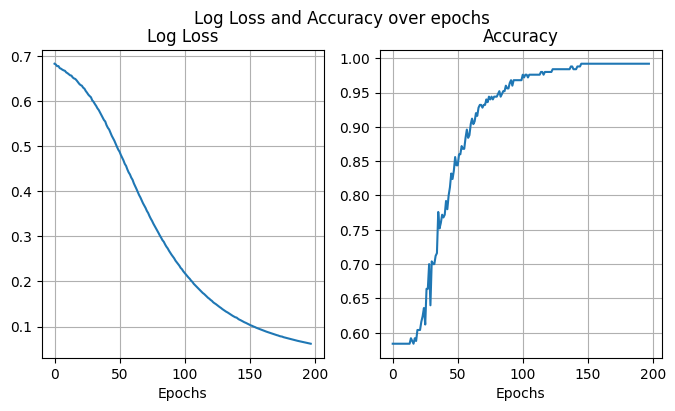

In [42]:
mlp_bow = mlp.Feedforward_Model(X_train_BOW, Y_train_BOW, units=mlp_bow_params.iloc[-1]['params_units'])
mlp_bow.train(LR=mlp_bow_params.iloc[-1]['params_learning_rate'], epochs=mlp_bow_params.iloc[-1]['params_epochs'])
mlp_bow.plot_loss_accuracy()

In [43]:
# Do some tests for vocab size
mlp_bow_vocab = comp.test_vocab_size(df,
                                     "MLP",
                                     "BOW",
                                     learning_rate=mlp_bow_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_bow_params.iloc[-1]['params_epochs'],
                                     units=mlp_bow_params.iloc[-1]['params_units'])

Initializing vocab-size test for MLP, with embedding BOW.
Params: 0.16473959155901144, 198, 7
Test started........
The result is: [(1000, 0.71), (2000, 0.66), (3000, 0.7), (4000, 0.66), (5000, 0.66), (6000, 0.73), (7000, 0.64), (8000, 0.75)]


In [44]:
# Tests for split ratio
mlp_bow_split = comp.test_split_ratio(dataset,
                                     "MLP",
                                     "BOW",
                                     learning_rate=mlp_bow_params.iloc[-1]['params_learning_rate'],
                                     epochs=mlp_bow_params.iloc[-1]['params_epochs'],
                                     units=mlp_bow_params.iloc[-1]['params_units'])

Initializing split test for MLP, with embedding BOW.
Params: 0.16473959155901144, 198, 7
Test started.....
The result is: [(0.1, 0.68), (0.2, 0.68), (0.3, 0.7067), (0.4, 0.67), (0.5, 0.604)]


In [87]:
"""
2.3) classical RNN with embedding encoding
"""
X_train_EBM, X_test_EBM, Y_train_EBM, Y_test_EBM = dataset.get_sequences(vocab_size=1000, maxlen=10)

In [88]:
rnn_emb_params = rnn.find_best_rnn(X_train_EBM, Y_train_EBM, X_test_EBM, Y_test_EBM, n_trials=3)

[I 2025-06-18 12:03:01,770] A new study created in memory with name: mlp_optimization


Epoch 1/168
4/4 [==============================] - 1s 51ms/step - loss: 0.7304 - accuracy: 0.4750 - val_loss: 0.6806 - val_accuracy: 0.4600
Epoch 2/168
4/4 [==============================] - 0s 8ms/step - loss: 0.7746 - accuracy: 0.5100 - val_loss: 1.2580 - val_accuracy: 0.2200
Epoch 3/168
4/4 [==============================] - 0s 7ms/step - loss: 0.9029 - accuracy: 0.4900 - val_loss: 1.0162 - val_accuracy: 0.2000
Epoch 4/168
4/4 [==============================] - 0s 7ms/step - loss: 0.7415 - accuracy: 0.4750 - val_loss: 0.4992 - val_accuracy: 0.8000
Epoch 5/168
4/4 [==============================] - 0s 7ms/step - loss: 0.7995 - accuracy: 0.5300 - val_loss: 0.7029 - val_accuracy: 0.2400
Epoch 6/168
4/4 [==============================] - 0s 7ms/step - loss: 0.7294 - accuracy: 0.4550 - val_loss: 0.7792 - val_accuracy: 0.5000
Epoch 7/168
4/4 [==============================] - 0s 7ms/step - loss: 0.6995 - accuracy: 0.5600 - val_loss: 0.6830 - val_accuracy: 0.6000
Epoch 8/168
4/4 [=========

[I 2025-06-18 12:03:06,691] Trial 0 finished with values: [0.8436923623085022, 0.5879999995231628] and parameters: {'epochs': 168, 'learning_rate': 0.3156013719386622, 'units': 4, 'two_layers': True, 'batch_size': 63}.


Epoch 1/130
2/2 [==============================] - 1s 113ms/step - loss: 0.6949 - accuracy: 0.4700 - val_loss: 0.5695 - val_accuracy: 0.7000
Epoch 2/130
2/2 [==============================] - 0s 18ms/step - loss: 0.7512 - accuracy: 0.6150 - val_loss: 0.7515 - val_accuracy: 0.5400
Epoch 3/130
2/2 [==============================] - 0s 18ms/step - loss: 0.6480 - accuracy: 0.6400 - val_loss: 0.8686 - val_accuracy: 0.6600
Epoch 4/130
2/2 [==============================] - 0s 17ms/step - loss: 0.8022 - accuracy: 0.6700 - val_loss: 0.5193 - val_accuracy: 0.8000
Epoch 5/130
2/2 [==============================] - 0s 17ms/step - loss: 0.5820 - accuracy: 0.7300 - val_loss: 0.6804 - val_accuracy: 0.7000
Epoch 6/130
2/2 [==============================] - 0s 17ms/step - loss: 0.5336 - accuracy: 0.7550 - val_loss: 0.8169 - val_accuracy: 0.5600
Epoch 7/130
2/2 [==============================] - 0s 16ms/step - loss: 0.5365 - accuracy: 0.7500 - val_loss: 0.9221 - val_accuracy: 0.5600
Epoch 8/130
2/2 [==

[I 2025-06-18 12:03:09,856] Trial 1 finished with values: [1.5639289617538452, 0.5759999752044678] and parameters: {'epochs': 130, 'learning_rate': 0.3198834393413302, 'units': 6, 'two_layers': False, 'batch_size': 183}.


Epoch 1/176
2/2 [==============================] - 1s 114ms/step - loss: 0.6919 - accuracy: 0.4900 - val_loss: 0.8235 - val_accuracy: 0.2000
Epoch 2/176
2/2 [==============================] - 0s 16ms/step - loss: 0.7245 - accuracy: 0.4700 - val_loss: 0.6442 - val_accuracy: 0.7000
Epoch 3/176
2/2 [==============================] - 0s 18ms/step - loss: 0.6137 - accuracy: 0.7550 - val_loss: 0.5199 - val_accuracy: 0.7600
Epoch 4/176
2/2 [==============================] - 0s 16ms/step - loss: 0.4999 - accuracy: 0.7900 - val_loss: 0.4522 - val_accuracy: 0.7800
Epoch 5/176
2/2 [==============================] - 0s 17ms/step - loss: 0.3614 - accuracy: 0.8400 - val_loss: 0.6151 - val_accuracy: 0.6800
Epoch 6/176
2/2 [==============================] - 0s 18ms/step - loss: 0.2568 - accuracy: 0.9200 - val_loss: 0.9803 - val_accuracy: 0.5600
Epoch 7/176
2/2 [==============================] - 0s 17ms/step - loss: 0.2056 - accuracy: 0.9300 - val_loss: 0.9498 - val_accuracy: 0.6200
Epoch 8/176
2/2 [==

[I 2025-06-18 12:03:13,913] Trial 2 finished with values: [3.33182430267334, 0.5519999861717224] and parameters: {'epochs': 176, 'learning_rate': 0.1459143119738374, 'units': 5, 'two_layers': False, 'batch_size': 148}.


In [89]:
rnn_emb_params

,loss,accuracy,params_batch_size,params_epochs,params_learning_rate,params_two_layers,params_units,time,trial_time,name
0,3.331824,0.552,148,176,0.145914,False,5,4.055351,4.055351,RNN_EBM
1,1.563929,0.576,183,130,0.319883,False,6,3.164524,3.164524,RNN_EBM
2,0.843692,0.588,63,168,0.315601,True,4,4.919290,4.919290,RNN_EBM


In [90]:
rnn_ebm = rnn.Recurrent_Model(X=X_train_EBM,
                              Y=Y_train_EBM,
                              input_dim=1004,
                              output_dim=1,
                              units=rnn_emb_params.iloc[-1]['params_units'],
                              rnn_type="RNN",
                              two_layers=rnn_emb_params.iloc[-1]['params_two_layers'])

rnn_ebm.train(LR=rnn_emb_params.iloc[-1]['params_learning_rate'],
              epochs=rnn_emb_params.iloc[-1]['params_epochs'],
              batch_size=rnn_emb_params.iloc[-1]['params_batch_size'],
              verbose=1,
              validation_split=0.2)


Epoch 1/168
4/4 [==============================] - 1s 50ms/step - loss: 0.7519 - accuracy: 0.4950 - val_loss: 0.8165 - val_accuracy: 0.3600
Epoch 2/168
4/4 [==============================] - 0s 7ms/step - loss: 0.7510 - accuracy: 0.4650 - val_loss: 0.6911 - val_accuracy: 0.4800
Epoch 3/168
4/4 [==============================] - 0s 7ms/step - loss: 0.7327 - accuracy: 0.5100 - val_loss: 0.6434 - val_accuracy: 0.7800
Epoch 4/168
4/4 [==============================] - 0s 6ms/step - loss: 0.6844 - accuracy: 0.5850 - val_loss: 0.6877 - val_accuracy: 0.5200
Epoch 5/168
4/4 [==============================] - 0s 7ms/step - loss: 0.7008 - accuracy: 0.5650 - val_loss: 0.6453 - val_accuracy: 0.7600
Epoch 6/168
4/4 [==============================] - 0s 7ms/step - loss: 0.6576 - accuracy: 0.5900 - val_loss: 0.5845 - val_accuracy: 0.6200
Epoch 7/168
4/4 [==============================] - 0s 7ms/step - loss: 0.6470 - accuracy: 0.6200 - val_loss: 0.6088 - val_accuracy: 0.6400
Epoch 8/168
4/4 [=========

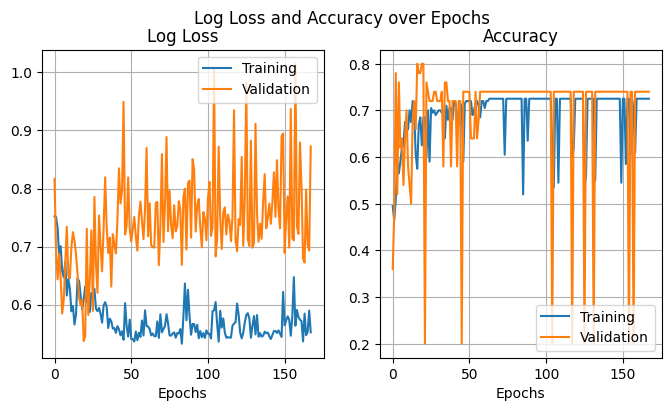

In [91]:
rnn_ebm.plot_loss_accuracy()

In [92]:
rnn_ebm_split = comp.test_split_ratio(dataset,
                                      "RNN",
                                      "EBM",
                                      learning_rate=rnn_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=rnn_emb_params.iloc[-1]['params_epochs'],
                                      units=rnn_emb_params.iloc[-1]['params_units'],
                                      batch_size=rnn_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=rnn_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing split test for RNN, with embedding EBM.
Params: 0.3156013719386622, 168, 4
Test started.....
The result is: [(0.1, 0.58), (0.2, 0.6), (0.3, 0.5867), (0.4, 0.43), (0.5, 0.584)]


In [93]:
rnn_ebm_vocab = comp.test_vocab_size(df,
                                      "RNN",
                                      "EBM",
                                      learning_rate=rnn_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=rnn_emb_params.iloc[-1]['params_epochs'],
                                      units=rnn_emb_params.iloc[-1]['params_units'],
                                      batch_size=rnn_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=rnn_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing vocab-size test for RNN, with embedding EBM.
Params: 0.3156013719386622, 168, 4
Test started........
The result is: [(1000, 0.59), (2000, 0.61), (3000, 0.55), (4000, 0.49), (5000, 0.59), (6000, 0.59), (7000, 0.59), (8000, 0.5)]


In [128]:
reload(prd)
reload(dat)
reload(mlp)
reload(tb)
reload(comp)
reload(rnn)

<module 'source.recurent_neural_networks' from 'C:\\Python_files\\DL_final2\\source\\recurent_neural_networks.py'>

In [129]:
"""
2.4) LSTM with embedding encoding
"""
lstm_emb_params = rnn.find_best_rnn(X_train_EBM, Y_train_EBM, X_test_EBM, Y_test_EBM, n_trials=2, rnn_type="LSTM")



[I 2025-06-18 12:34:24,023] A new study created in memory with name: mlp_optimization


Epoch 1/155
2/2 [==============================] - 1s 203ms/step - loss: 0.7369 - accuracy: 0.4750 - val_loss: 0.7117 - val_accuracy: 0.2000
Epoch 2/155
2/2 [==============================] - 0s 18ms/step - loss: 0.6614 - accuracy: 0.5700 - val_loss: 0.5605 - val_accuracy: 0.8000
Epoch 3/155
2/2 [==============================] - 0s 18ms/step - loss: 0.6207 - accuracy: 0.5300 - val_loss: 0.5040 - val_accuracy: 0.8000
Epoch 4/155
2/2 [==============================] - 0s 18ms/step - loss: 0.5375 - accuracy: 0.6350 - val_loss: 0.5649 - val_accuracy: 0.7600
Epoch 5/155
2/2 [==============================] - 0s 18ms/step - loss: 0.4027 - accuracy: 0.9000 - val_loss: 0.7796 - val_accuracy: 0.5600
Epoch 6/155
2/2 [==============================] - 0s 18ms/step - loss: 0.2675 - accuracy: 0.9450 - val_loss: 0.9338 - val_accuracy: 0.5400
Epoch 7/155
2/2 [==============================] - 0s 17ms/step - loss: 0.2256 - accuracy: 0.9300 - val_loss: 0.9397 - val_accuracy: 0.6200
Epoch 8/155
2/2 [==

[I 2025-06-18 12:34:28,370] Trial 0 finished with values: [3.1771738529205322, 0.5440000295639038] and parameters: {'epochs': 155, 'learning_rate': 0.25309416318515066, 'units': 3, 'two_layers': False, 'batch_size': 104}.


Epoch 1/148
2/2 [==============================] - 1s 207ms/step - loss: 0.8741 - accuracy: 0.5250 - val_loss: 0.6923 - val_accuracy: 0.5800
Epoch 2/148
2/2 [==============================] - 0s 19ms/step - loss: 0.6630 - accuracy: 0.6450 - val_loss: 0.7892 - val_accuracy: 0.2000
Epoch 3/148
2/2 [==============================] - 0s 18ms/step - loss: 0.5578 - accuracy: 0.6700 - val_loss: 0.7416 - val_accuracy: 0.6400
Epoch 4/148
2/2 [==============================] - 0s 17ms/step - loss: 0.3812 - accuracy: 0.9050 - val_loss: 0.4803 - val_accuracy: 0.8400
Epoch 5/148
2/2 [==============================] - 0s 18ms/step - loss: 0.2266 - accuracy: 0.9300 - val_loss: 1.0468 - val_accuracy: 0.5800
Epoch 6/148
2/2 [==============================] - 0s 17ms/step - loss: 0.1631 - accuracy: 0.9500 - val_loss: 1.1013 - val_accuracy: 0.6000
Epoch 7/148
2/2 [==============================] - 0s 18ms/step - loss: 0.1223 - accuracy: 0.9650 - val_loss: 1.4238 - val_accuracy: 0.6200
Epoch 8/148
2/2 [==

[I 2025-06-18 12:34:32,544] Trial 1 finished with values: [2.2919044494628906, 0.6240000128746033] and parameters: {'epochs': 148, 'learning_rate': 0.21300481615169514, 'units': 10, 'two_layers': False, 'batch_size': 106}.


In [130]:
lstm_emb_params

,loss,accuracy,params_batch_size,params_epochs,params_learning_rate,params_two_layers,params_units,time,trial_time,name
0,3.177174,0.544,104,155,0.253094,False,3,4.346160,4.346160,LSTM_EBM
1,2.291904,0.624,106,148,0.213005,False,10,4.172203,4.172203,LSTM_EBM


In [131]:
lstm_ebm = rnn.Recurrent_Model(X=X_train_EBM,
                              Y=Y_train_EBM,
                              input_dim=1004,
                              output_dim=1,
                              units=lstm_emb_params.iloc[-1]['params_units'],
                              rnn_type="LSTM",
                              two_layers=lstm_emb_params.iloc[-1]['params_two_layers'])



Epoch 1/148
2/2 [==============================] - 1s 205ms/step - loss: 0.6959 - accuracy: 0.5150 - val_loss: 0.9724 - val_accuracy: 0.2000
Epoch 2/148
2/2 [==============================] - 0s 18ms/step - loss: 0.7608 - accuracy: 0.4400 - val_loss: 0.6166 - val_accuracy: 0.8000
Epoch 3/148
2/2 [==============================] - 0s 17ms/step - loss: 0.7009 - accuracy: 0.5300 - val_loss: 0.6399 - val_accuracy: 0.8000
Epoch 4/148
2/2 [==============================] - 0s 17ms/step - loss: 0.6887 - accuracy: 0.5350 - val_loss: 0.6979 - val_accuracy: 0.4400
Epoch 5/148
2/2 [==============================] - 0s 18ms/step - loss: 0.6722 - accuracy: 0.5950 - val_loss: 0.6938 - val_accuracy: 0.6400
Epoch 6/148
2/2 [==============================] - 0s 18ms/step - loss: 0.6277 - accuracy: 0.6850 - val_loss: 0.6373 - val_accuracy: 0.6800
Epoch 7/148
2/2 [==============================] - 0s 18ms/step - loss: 0.5163 - accuracy: 0.7750 - val_loss: 0.8704 - val_accuracy: 0.5600
Epoch 8/148
2/2 [==

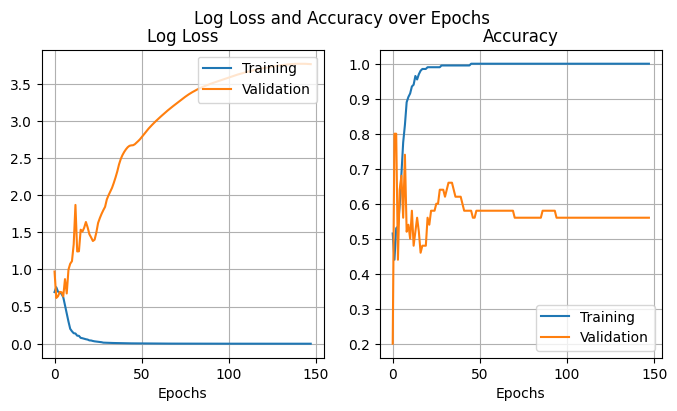

In [132]:
lstm_ebm.train(LR=lstm_emb_params.iloc[-1]['params_learning_rate'],
              epochs=lstm_emb_params.iloc[-1]['params_epochs'],
              batch_size=lstm_emb_params.iloc[-1]['params_batch_size'],
              verbose=1,
              validation_split=0.2)

lstm_ebm.plot_loss_accuracy()


In [134]:
lstm_ebm_split = comp.test_split_ratio(dataset,
                                      "LSTM",
                                      "EBM",
                                      learning_rate=lstm_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=lstm_emb_params.iloc[-1]['params_epochs'],
                                      units=lstm_emb_params.iloc[-1]['params_units'],
                                      batch_size=lstm_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=lstm_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing split test for LSTM, with embedding EBM.
Params: 0.21300481615169514, 148, 10
Test started.....
The result is: [(0.1, 0.5), (0.2, 0.63), (0.3, 0.58), (0.4, 0.535), (0.5, 0.568)]


In [135]:
lstm_ebm_vocab = comp.test_vocab_size(df,
                                      "LSTM",
                                      "EBM",
                                      learning_rate=lstm_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=lstm_emb_params.iloc[-1]['params_epochs'],
                                      units=lstm_emb_params.iloc[-1]['params_units'],
                                      batch_size=lstm_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=lstm_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing vocab-size test for LSTM, with embedding EBM.
Params: 0.21300481615169514, 148, 10
Test started........
The result is: [(1000, 0.63), (2000, 0.58), (3000, 0.57), (4000, 0.58), (5000, 0.6), (6000, 0.52), (7000, 0.71), (8000, 0.49)]


In [143]:
"""
2.5) GRU with embedding encoding
"""
gru_emb_params = rnn.find_best_rnn(X_train_EBM, Y_train_EBM, X_test_EBM, Y_test_EBM, n_trials=2, rnn_type="GRU")

[I 2025-06-18 12:42:05,223] A new study created in memory with name: mlp_optimization


Epoch 1/147
23/23 [==============================] - 2s 17ms/step - loss: 0.8065 - accuracy: 0.4700 - val_loss: 0.7777 - val_accuracy: 0.4400
Epoch 2/147
23/23 [==============================] - 0s 4ms/step - loss: 0.7803 - accuracy: 0.4900 - val_loss: 0.7823 - val_accuracy: 0.2200
Epoch 3/147
23/23 [==============================] - 0s 4ms/step - loss: 0.6726 - accuracy: 0.5900 - val_loss: 0.6154 - val_accuracy: 0.7400
Epoch 4/147
23/23 [==============================] - 0s 4ms/step - loss: 0.6400 - accuracy: 0.6500 - val_loss: 0.5558 - val_accuracy: 0.7600
Epoch 5/147
23/23 [==============================] - 0s 4ms/step - loss: 0.5823 - accuracy: 0.7100 - val_loss: 0.9466 - val_accuracy: 0.5800
Epoch 6/147
23/23 [==============================] - 0s 4ms/step - loss: 0.6206 - accuracy: 0.7350 - val_loss: 0.6232 - val_accuracy: 0.7600
Epoch 7/147
23/23 [==============================] - 0s 4ms/step - loss: 0.5849 - accuracy: 0.7400 - val_loss: 0.5801 - val_accuracy: 0.7000
Epoch 8/147


[I 2025-06-18 12:42:19,995] Trial 0 finished with values: [0.986782431602478, 0.5320000052452087] and parameters: {'epochs': 147, 'learning_rate': 0.26100043902810244, 'units': 9, 'two_layers': True, 'batch_size': 9}.


Epoch 1/190
2/2 [==============================] - 2s 315ms/step - loss: 1.0184 - accuracy: 0.4900 - val_loss: 0.4930 - val_accuracy: 0.8000
Epoch 2/190
2/2 [==============================] - 0s 21ms/step - loss: 0.6906 - accuracy: 0.5750 - val_loss: 0.8203 - val_accuracy: 0.2000
Epoch 3/190
2/2 [==============================] - 0s 21ms/step - loss: 0.6875 - accuracy: 0.4700 - val_loss: 0.6610 - val_accuracy: 0.6800
Epoch 4/190
2/2 [==============================] - 0s 20ms/step - loss: 0.5738 - accuracy: 0.7100 - val_loss: 0.6837 - val_accuracy: 0.7000
Epoch 5/190
2/2 [==============================] - 0s 20ms/step - loss: 0.4574 - accuracy: 0.7800 - val_loss: 0.6979 - val_accuracy: 0.7200
Epoch 6/190
2/2 [==============================] - 0s 20ms/step - loss: 0.3646 - accuracy: 0.8500 - val_loss: 1.2170 - val_accuracy: 0.3400
Epoch 7/190
2/2 [==============================] - 0s 20ms/step - loss: 0.3678 - accuracy: 0.8050 - val_loss: 0.8500 - val_accuracy: 0.6800
Epoch 8/190
2/2 [==

[I 2025-06-18 12:42:26,424] Trial 1 finished with values: [1.698224663734436, 0.5640000104904175] and parameters: {'epochs': 190, 'learning_rate': 0.3092639331137351, 'units': 6, 'two_layers': True, 'batch_size': 106}.


In [144]:
gru_emb_params

,loss,accuracy,params_batch_size,params_epochs,params_learning_rate,params_two_layers,params_units,time,trial_time,name
0,0.986782,0.532,9,147,0.261000,True,9,14.771228,14.771228,GRU_EBM
1,1.698225,0.564,106,190,0.309264,True,6,6.427160,6.427160,GRU_EBM


Epoch 1/190
2/2 [==============================] - 2s 308ms/step - loss: 1.1970 - accuracy: 0.5150 - val_loss: 2.7287 - val_accuracy: 0.2000
Epoch 2/190
2/2 [==============================] - 0s 20ms/step - loss: 1.2478 - accuracy: 0.4700 - val_loss: 0.5530 - val_accuracy: 0.8000
Epoch 3/190
2/2 [==============================] - 0s 18ms/step - loss: 0.7188 - accuracy: 0.5350 - val_loss: 0.6061 - val_accuracy: 0.7800
Epoch 4/190
2/2 [==============================] - 0s 18ms/step - loss: 0.6551 - accuracy: 0.6250 - val_loss: 0.7755 - val_accuracy: 0.7200
Epoch 5/190
2/2 [==============================] - 0s 19ms/step - loss: 0.5784 - accuracy: 0.7800 - val_loss: 0.7070 - val_accuracy: 0.7000
Epoch 6/190
2/2 [==============================] - 0s 20ms/step - loss: 0.4998 - accuracy: 0.7900 - val_loss: 0.6595 - val_accuracy: 0.7400
Epoch 7/190
2/2 [==============================] - 0s 19ms/step - loss: 0.4411 - accuracy: 0.8100 - val_loss: 0.6223 - val_accuracy: 0.7200
Epoch 8/190
2/2 [==

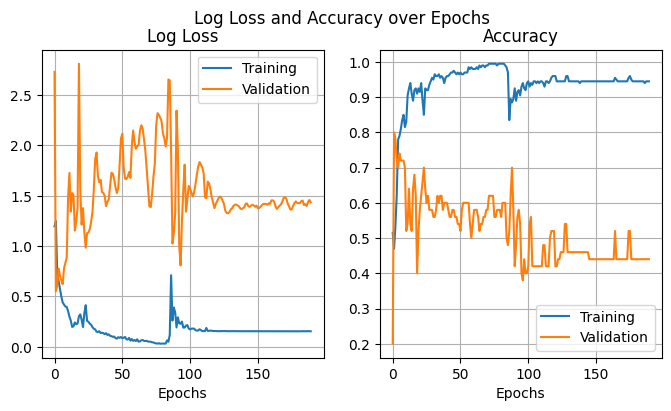

In [145]:
gru_ebm = rnn.Recurrent_Model(X=X_train_EBM,
                              Y=Y_train_EBM,
                              input_dim=1004,
                              output_dim=1,
                              units=gru_emb_params.iloc[-1]['params_units'],
                              rnn_type="GRU",
                              two_layers=gru_emb_params.iloc[-1]['params_two_layers'])

gru_ebm.train(LR=gru_emb_params.iloc[-1]['params_learning_rate'],
              epochs=gru_emb_params.iloc[-1]['params_epochs'],
              batch_size=gru_emb_params.iloc[-1]['params_batch_size'],
              verbose=1,
              validation_split=0.2)

gru_ebm.plot_loss_accuracy()

In [146]:
gru_ebm_split = comp.test_split_ratio(dataset,
                                      "GRU",
                                      "EBM",
                                      learning_rate=gru_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=gru_emb_params.iloc[-1]['params_epochs'],
                                      units=gru_emb_params.iloc[-1]['params_units'],
                                      batch_size=gru_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=gru_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing split test for GRU, with embedding EBM.
Params: 0.3092639331137351, 190, 6
Test started.....
The result is: [(0.1, 0.54), (0.2, 0.61), (0.3, 0.4133), (0.4, 0.605), (0.5, 0.524)]


In [147]:
gru_ebm_vocab = comp.test_vocab_size(df,
                                      "GRU",
                                      "EBM",
                                      learning_rate=gru_emb_params.iloc[-1]['params_learning_rate'],
                                      epochs=gru_emb_params.iloc[-1]['params_epochs'],
                                      units=gru_emb_params.iloc[-1]['params_units'],
                                      batch_size=gru_emb_params.iloc[-1]['params_batch_size'],
                                      two_layers=gru_emb_params.iloc[-1]['params_two_layers']
                                      )

Initializing vocab-size test for GRU, with embedding EBM.
Params: 0.3092639331137351, 190, 6
Test started........
The result is: [(1000, 0.5), (2000, 0.55), (3000, 0.59), (4000, 0.51), (5000, 0.61), (6000, 0.57), (7000, 0.53), (8000, 0.54)]


In [149]:
"""
3) Upload data to the class for comparison
"""
table = tb.Table()
table.add_record(name="rnn_emb",
                 epoch=rnn_emb_params.iloc[-1]["params_epochs"],
                 lr=rnn_emb_params.iloc[-1]["params_learning_rate"],
                 accuracy=rnn_emb_params.iloc[-1]["accuracy"],
                 loss=rnn_emb_params.iloc[-1]["loss"],
                 units=rnn_emb_params.iloc[-1]["params_units"],
                 avg_time=rnn_emb_params.iloc[-1]["time"],
                 batch_size=rnn_emb_params.iloc[-1]["params_batch_size"],
                 two_layers=rnn_emb_params.iloc[-1]["params_two_layers"],
                 split_accuracy=rnn_ebm_split,
                 vocab_accuracy=rnn_ebm_vocab)

table.add_record(name="lstm_emb",
                 epoch=lstm_emb_params.iloc[-1]["params_epochs"],
                 lr=lstm_emb_params.iloc[-1]["params_learning_rate"],
                 accuracy=lstm_emb_params.iloc[-1]["accuracy"],
                 loss=lstm_emb_params.iloc[-1]["loss"],
                 units=lstm_emb_params.iloc[-1]["params_units"],
                 avg_time=lstm_emb_params.iloc[-1]["time"],
                 batch_size=lstm_emb_params.iloc[-1]["params_batch_size"],
                 two_layers=lstm_emb_params.iloc[-1]["params_two_layers"],
                 split_accuracy=lstm_ebm_split,
                 vocab_accuracy=lstm_ebm_vocab)

table.add_record(name="gru_emb",
                 epoch=gru_emb_params.iloc[-1]["params_epochs"],
                 lr=gru_emb_params.iloc[-1]["params_learning_rate"],
                 accuracy=gru_emb_params.iloc[-1]["accuracy"],
                 loss=gru_emb_params.iloc[-1]["loss"],
                 units=gru_emb_params.iloc[-1]["params_units"],
                 avg_time=gru_emb_params.iloc[-1]["time"],
                 batch_size=gru_emb_params.iloc[-1]["params_batch_size"],
                 two_layers=gru_emb_params.iloc[-1]["params_two_layers"],
                 split_accuracy=gru_ebm_split,
                 vocab_accuracy=gru_ebm_vocab)

table.add_record(name="mlp_tdidf",
                 epoch=mlp_tdidf_params.iloc[-1]["params_epochs"],
                 lr=mlp_tdidf_params.iloc[-1]["params_learning_rate"],
                 accuracy=mlp_tdidf_params.iloc[-1]["accuracy"],
                 loss=mlp_tdidf_params.iloc[-1]["loss"],
                 units=mlp_tdidf_params.iloc[-1]["params_units"],
                 avg_time=mlp_tdidf_params.iloc[-1]["time"],
                 split_accuracy=mlp_tdidf_split,
                 vocab_accuracy=mlp_tdidf_vocab)

table.add_record(name="mlp_bow",
                 epoch=mlp_bow_params.iloc[-1]["params_epochs"],
                 lr=mlp_bow_params.iloc[-1]["params_learning_rate"],
                 accuracy=mlp_bow_params.iloc[-1]["accuracy"],
                 loss=mlp_bow_params.iloc[-1]["loss"],
                 units=mlp_bow_params.iloc[-1]["params_units"],
                 avg_time=mlp_bow_params.iloc[-1]["time"],
                 split_accuracy=mlp_bow_split,
                 vocab_accuracy=mlp_bow_vocab)

Adding a new record with params: name: rnn_emb, epoch: 168, lr: 0.3156013719386622, units: 4, average time: 4.91929
Adding a new record with params: name: lstm_emb, epoch: 148, lr: 0.21300481615169514, units: 10, average time: 4.172203
Adding a new record with params: name: gru_emb, epoch: 190, lr: 0.3092639331137351, units: 6, average time: 6.42716
Adding a new record with params: name: mlp_tdidf, epoch: 128, lr: 0.24133491544831018, units: 6, average time: 1.197851
Adding a new record with params: name: mlp_bow, epoch: 198, lr: 0.16473959155901144, units: 7, average time: 1.26253


In [150]:
table.show(tabulate_view=False)


Table info:
<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 4
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5 non-null      object 
 1   epochs          5 non-null      int64  
 2   accuracy        5 non-null      float64
 3   loss            5 non-null      float64
 4   lr              5 non-null      float64
 5   units           5 non-null      int64  
 6   avg_time        5 non-null      float64
 7   split_accuracy  5 non-null      object 
 8   vocab_accuracy  5 non-null      object 
 9   two_layers      5 non-null      int64  
 10  batch_size      5 non-null      int64  
dtypes: float64(4), int64(4), object(3)
memory usage: 480.0+ bytes

Records preview:


,name,epochs,accuracy,loss,lr,units,avg_time,split_accuracy,vocab_accuracy,two_layers,batch_size
0,rnn_emb,168,0.588,0.843692,0.315601,4,4.919290,"[(0.1, 0.58), (0.2, 0.6), (0.3, 0.5867), (0.4,...","[(1000, 0.59), (2000, 0.61), (3000, 0.55), (40...",1,63
1,lstm_emb,148,0.624,2.291904,0.213005,10,4.172203,"[(0.1, 0.5), (0.2, 0.63), (0.3, 0.58), (0.4, 0...","[(1000, 0.63), (2000, 0.58), (3000, 0.57), (40...",0,106
2,gru_emb,190,0.564,1.698225,0.309264,6,6.427160,"[(0.1, 0.54), (0.2, 0.61), (0.3, 0.4133), (0.4...","[(1000, 0.5), (2000, 0.55), (3000, 0.59), (400...",1,106
3,mlp_tdidf,128,0.730,0.560689,0.241335,6,1.197851,"[(0.1, 0.72), (0.2, 0.67), (0.3, 0.6133), (0.4...","[(1000, 0.69), (2000, 0.58), (3000, 0.64), (40...",0,0
4,mlp_bow,198,0.716,0.793085,0.164740,7,1.262530,"[(0.1, 0.68), (0.2, 0.68), (0.3, 0.7067), (0.4...","[(1000, 0.71), (2000, 0.66), (3000, 0.7), (400...",0,0


In [151]:
table.print_best_accuracy()


Top 3 best accuracies:
1) 0.7300 for mlp_tdidf
2) 0.7160 for mlp_bow
3) 0.6240 for lstm_emb


In [152]:
all = tb.All_trials_table()
all.add_record(mlp_tdidf_params)
all.add_record(rnn_emb_params)
all.add_record(mlp_bow_params)
all.add_record(lstm_emb_params)
all.add_record(gru_emb_params)
all.show(tabulate_view=False)

Adding a new record with params.
Adding a new record with params.
Adding a new record with params.
Adding a new record with params.
Adding a new record with params.

Table info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   loss                  13 non-null     float64
 1   accuracy              13 non-null     float64
 2   params_epochs         13 non-null     object 
 3   params_learning_rate  13 non-null     float64
 4   params_units          13 non-null     object 
 5   time                  13 non-null     float64
 6   trial_time            13 non-null     float64
 7   name                  13 non-null     object 
 8   params_batch_size     7 non-null      float64
 9   params_two_layers     7 non-null      object 
dtypes: float64(6), object(4)
memory usage: 1.1+ KB

Records preview:


C:\Python_files\DL_final2\source\table.py:130: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  


,loss,accuracy,params_epochs,params_learning_rate,params_units,time,trial_time,name,params_batch_size,params_two_layers
0,0.634810,0.620,148,0.169651,5,1.301589,1.301589,MLP_TDIDF,NaN,NaN
1,0.588630,0.700,193,0.337498,5,1.596172,1.596172,MLP_TDIDF,NaN,NaN
2,0.560689,0.730,128,0.241335,6,1.197851,1.197851,MLP_TDIDF,NaN,NaN
3,3.331824,0.552,176,0.145914,5,4.055351,4.055351,RNN_EBM,148.0,False
4,1.563929,0.576,130,0.319883,6,3.164524,3.164524,RNN_EBM,183.0,False
5,0.843692,0.588,168,0.315601,4,4.919290,4.919290,RNN_EBM,63.0,True
6,0.671654,0.588,114,0.025900,8,0.839582,0.839582,MLP_BOW,NaN,NaN
7,0.925599,0.712,142,0.377577,10,0.976144,0.976144,MLP_BOW,NaN,NaN
8,0.793085,0.716,198,0.164740,7,1.262530,1.262530,MLP_BOW,NaN,NaN
9,3.177174,0.544,155,0.253094,3,4.346160,4.346160,LSTM_EBM,104.0,False


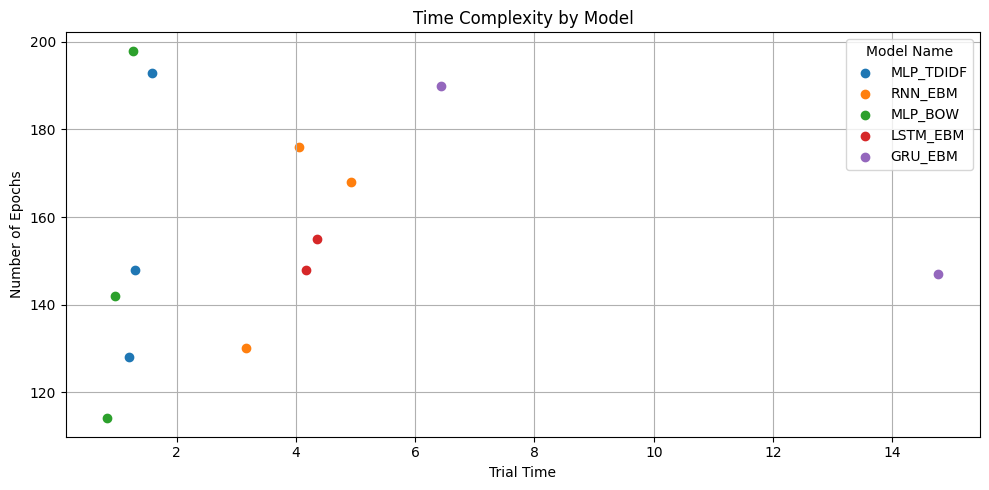

In [153]:
all.plot_time_complexity()

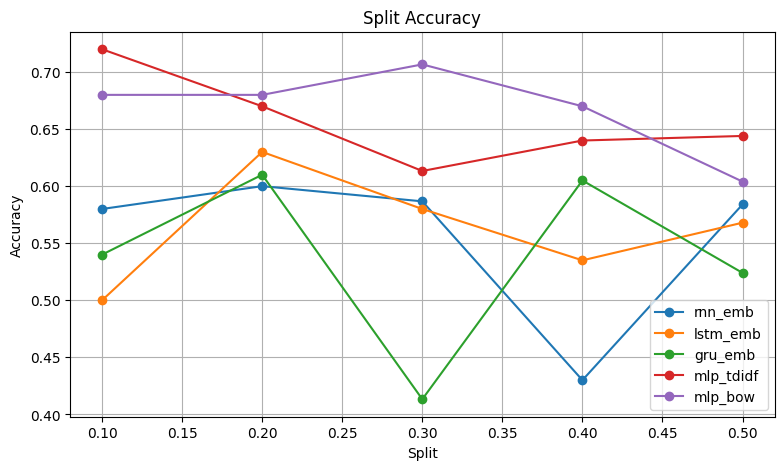

In [154]:
table.plot_split_accuracy()

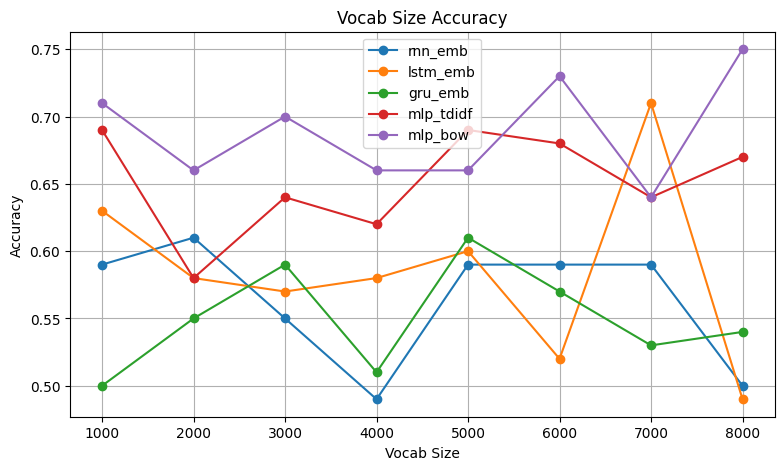

In [155]:
table.plot_vocab_accuracy()